### Plot CASE STSE output

In [2]:
import cmocean as cmo
import datetime as dt
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sc
import scipy.io as sio
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [24]:
def read_bin(file, shape, k=0, dtype='>f4'):
    '''Read the whole binary file
    shape:: tuple with the final shape of the 
            data in order (nt,ny,nx,nz) for 
            3D + time fields or (nt,ny,nx) for 
            2D + time fields.
    dtype:: string with any accepted python format. 
            Most common are '>f8' equivalent to real*8, 
            ieee-b and '>f4' equivalent to real*4, ieee-b.
    RETURNS
    Numpy array of data of shape "shape".
    '''
#    with open(file, 'r') as f:
#        cc = np.fromfile(f,dtype=dtype)
#   return(np.reshape(cc, shape, order='C'))
    shape_arr = np.array(shape)
    nnn = shape_arr.prod()
    WORDLENGTH = 4 # default word length
    with open(file, "rb") as f:
        if k=='all': # Load the whole thing
            cc=np.fromfile(f,dtype=dtype)
        else:
            offs=nnn*k*WORDLENGTH
            #f.seek(nnn*k*WORDLENGTH)
            cc=np.fromfile(f,offset=offs,count=nnn,dtype=dtype)
    return(np.reshape(cc, shape, order='C'))


def load_bat(file):
    '''Load X, Y and Z arrays from mat file'''
    bathy = sio.loadmat(bathy_file)
    return(bathy['XC'][:], bathy['YC'][:], bathy['RC'][:])

def matlab2datetime(matlab_datenum):
    day = dt.datetime.fromordinal(int(matlab_datenum))
    dayfrac = dt.timedelta(days=matlab_datenum%1) - dt.timedelta(days = 366)
    return day + dayfrac

def plot_ssh(ax,XC,YC,eta_slice,date_str, vmin=-0.15, vmax=0.15):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(XC[:,0],YC[0,:],eta_slice, cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
    cmap = cmo.cm.balance
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar_ax = fig.add_axes([0.89, 0.125, 0.025, 0.76])
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      cax=cbar_ax, orientation='vertical', 
                      format='%1.2f', label=r'Free surface (m)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(matlab2datetime(date_str))
    ax.set_aspect(1)
    return(ax)

def plot_vel(ax,XC,YC,v_slice,date_str, vmin=-0.8, vmax=0.8):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(XC[:,0],YC[0,:],v_slice, cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(pc, ax=ax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(matlab2datetime(date_str))
    ax.set_aspect(1)
    return(ax)

def plot_fld_anim(ax,XC,YC,eta_slice,date_str,U,V, vmin=-0.15, vmax=0.15,cmap=cmo.cm.balance,clab=r'Free surface (m)'):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(XC[:,0],YC[0,:],eta_slice, cmap=cmap, vmin=vmin, vmax=vmax)
    cmap = cmap
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar_ax = fig.add_axes([0.89, 0.125, 0.022, 0.755])
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      cax=cbar_ax, orientation='vertical', 
                      format='%1.2f', label=clab)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(matlab2datetime(date_str))
    ax.set_aspect(1)
    width = XC[-1,0]-XC[-59,0]
    height = YC[0,59]-YC[0,0]
    rect = patches.Rectangle((XC[-60,0],YC[0,0]),width,height,linewidth=2,edgecolor='k', facecolor='none')
    ax.add_patch(rect)
    q = ax.quiver(XC[::10,::10],YC[::10,::10],np.transpose(U[::10,::10]),np.transpose(V[::10,::10]))
    ax.quiverkey(q, X=0.75,Y=0.85, U=0.5,
             label='0.5 m s$^{-1}$', labelpos='E')

    return(ax)

def plot_fld_zoom(ax,XC,YC,eta_slice,date_str,U,V,vmin=-0.15,vmax=0.15,cmap=cmo.cm.balance):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(XC[-60:,0],YC[0,:60],eta_slice[:60,-60:], cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(matlab2datetime(date_str))
    ax.set_aspect(1)
    width = XC[-1,0]-XC[-60,0]
    height = YC[0,60]-YC[0,0]
    rect = patches.Rectangle((XC[-60,0],YC[0,0]),width,height,linewidth=3,edgecolor='k', facecolor='none')
    ax.add_patch(rect)
    UU = np.transpose(U)
    VV = np.transpose(V)
    q = ax.quiver(XC[-60::3,0:60:3],YC[-60::3,0:60:3],UU[-60::3,0:60:3],VV[-60::3,0:60:3])
    ax.quiverkey(q, X=0.7, Y=0.85, U=0.5,
                 label='0.5 m s$^{-1}$', labelpos='E')

    ax.set_xlim(XC[-60,0],XC[-1,0],)
    ax.set_ylim(YC[0,0],YC[0,60],)
    
    return(ax)



In [4]:
bathy_file = '/Volumes/MOBY/CASE-CCS/full_domain/grid.mat'
fmt_file = '/Volumes/MOBY/CASE-CCS/full_domain/FMT.mat'

fpath = '/Volumes/MOBY/CASE-CCS/full_domain/'
dpath = '/Volumes/MOBY/CASE-CCS/full_domain/'

In [5]:
XC, YC, ZC = load_bat(bathy_file)

nxc = len(XC[:])
nyc = len(YC[0,:]) 
nzc = len(ZC[:])
nt = 4656

In [6]:
# Read date strings
date_strs = read_bin(dpath+'TIME_CCS_2007_2019.bin', (nt), k=0)

# Read SSH
eta = read_bin(dpath+'Eta_MIT_CCS_2007_2019_fulldomain.bin', (nt,nyc,nxc), k=0)

In [7]:
# Read U surface . I need to be able to read only slices! This too expensive!
vel = read_bin(dpath+'U_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=1)
U = vel[0,:,:]

In [8]:
# Read V surface
vel = read_bin(dpath+'V_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc),k=1)
V = vel[0,:,:]

del vel

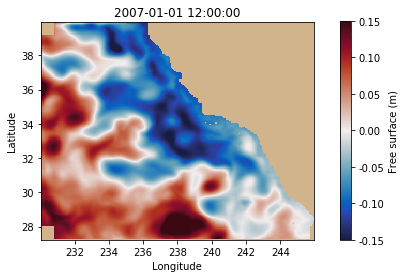

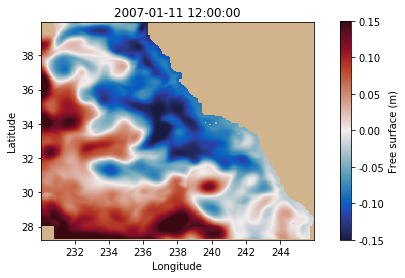

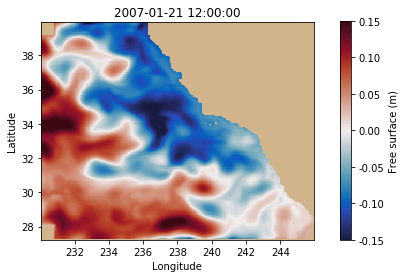

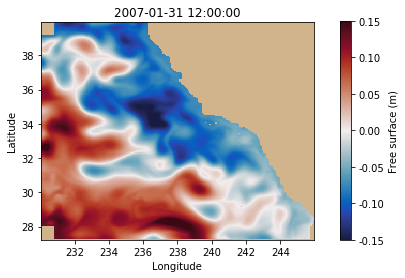

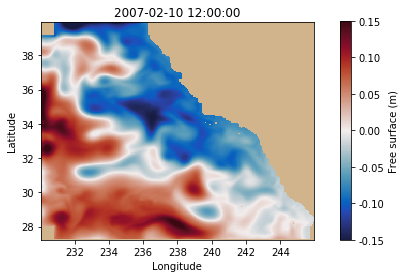

In [9]:
for tt in range(0,50,10):
    eta_sl = eta[tt,:,:]
    date_str = date_strs[tt]
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    ax = plot_ssh(ax,XC,YC,eta_sl,date_str)
    plt.show()

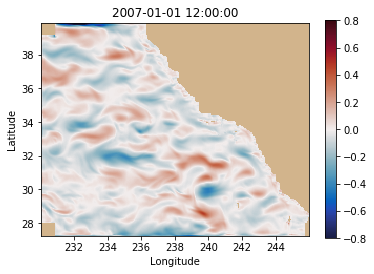

In [10]:
tt=0   
u_sl = U[:,:]
date_str = date_strs[0]
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax = plot_vel(ax,XC,YC,u_sl,date_str)
plt.show()

### SSH - animation

In [29]:
def init():
    tt=2922
    eta_sl = eta[tt,:,:]
    date_str = date_strs[tt]
    
    # Read U surface . I need to be able to read only slices! This too expensive!
    vel = read_bin(dpath+'U_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt, )
    U = vel[0,:,:]
    
    # Read U surface . I need to be able to read only slices! This too expensive!
    vel = read_bin(dpath+'V_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt)
    V = vel[0,:,:]
    ax = plot_fld_anim(ax1,XC,YC,eta_sl,date_str,U,V, cmap=cmap, clab=clab)
    axx = plot_fld_zoom(ax2,XC,YC,eta_sl,date_str,U,V, cmap=cmap)
    
def animate(ttt):
    tt = ttt+2922 #2015
    eta_sl = eta[tt,:,:]
    date_str = date_strs[tt]
    
    # Read U surface . I need to be able to read only slices! This too expensive!
    vel = read_bin(dpath+'U_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt)
    U = vel[0,:,:]
    
    # Read U surface . I need to be able to read only slices! This too expensive!
    vel = read_bin(dpath+'V_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt)
    V = vel[0,:,:]
    
    ax = plot_fld_anim(ax1,XC,YC,eta_sl,date_str,U,V,cmap=cmap, clab=clab)
    axx = plot_fld_zoom(ax2,XC,YC,eta_sl,date_str,U,V, cmap=cmap)
    print(ttt)
    
   

In [28]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

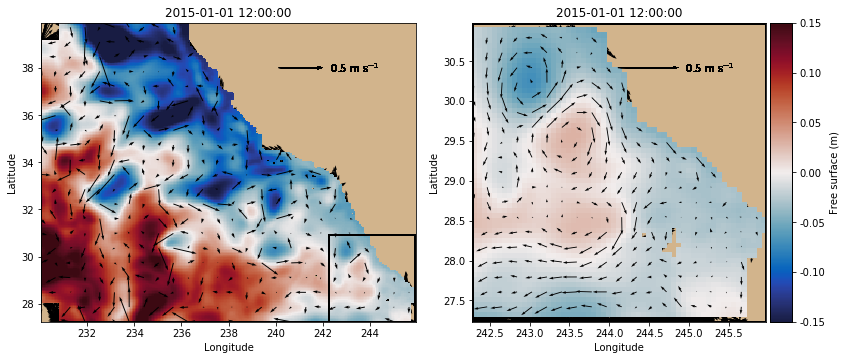

In [23]:
cmap=cmo.cm.balance
clab=r'Free surface (m)'

fig = plt.figure(figsize=(14,5.5))
gs = GridSpec(1,2, width_ratios=[1,0.7], wspace=0.0)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

anim = animation.FuncAnimation(fig, animate, init_func=init,blit=False, frames=365, repeat=False)
anim.save('ssh_2015.mp4', writer=writer)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

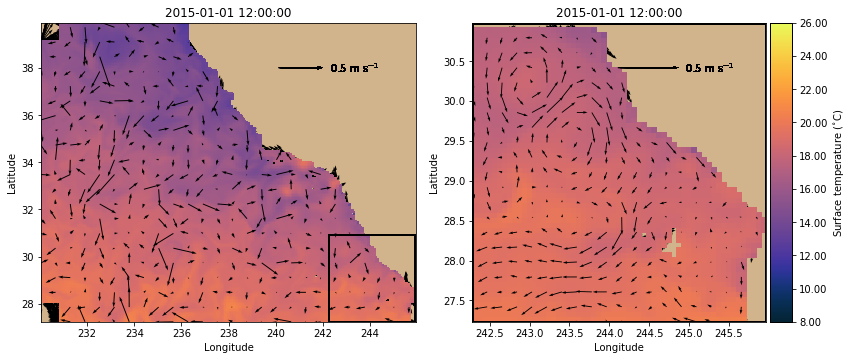

In [55]:
def init_T():
    tt=2922
    date_str = date_strs[tt]
    temp = read_bin(dpath+'T_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt )
    TT = temp[0,:,:]
    # Read U surface . I need to be able to read only slices! This too expensive!
    vel = read_bin(dpath+'U_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt )
    U = vel[0,:,:]
    
    # Read U surface . I need to be able to read only slices! This too expensive!
    vel = read_bin(dpath+'V_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt)
    V = vel[0,:,:]
    ax = plot_fld_anim(ax1,XC,YC,TT,date_str,U,V, cmap=cmap, clab=clab, vmin=vmin, vmax=vmax)
    axx = plot_fld_zoom(ax2,XC,YC,TT,date_str,U,V, cmap=cmap, vmin=vmin, vmax=vmax)
    
def animate_T(ttt):
    tt = ttt+2922#2015
    temp = read_bin(dpath+'T_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt )
    TT = temp[0,:,:]
    date_str = date_strs[tt]
    
    # Read U surface . I need to be able to read only slices! This too expensive!
    vel = read_bin(dpath+'U_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt)
    U = vel[0,:,:]
    
    # Read U surface . I need to be able to read only slices! This too expensive!
    vel = read_bin(dpath+'V_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt)
    V = vel[0,:,:]
    
    ax = plot_fld_anim(ax1,XC,YC,TT,date_str,U,V,cmap=cmap, clab=clab, vmin=vmin, vmax=vmax)
    axx = plot_fld_zoom(ax2,XC,YC,TT,date_str,U,V, cmap=cmap, vmin=vmin, vmax=vmax)
    print(ttt)

cmap=cmo.cm.thermal
clab=r'Surface temperature ($^{\circ}$C)'
vmin=8
vmax=26

fig = plt.figure(figsize=(14,5.5))
gs = GridSpec(1,2, width_ratios=[1,0.7], wspace=0.0)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

anim = animation.FuncAnimation(fig, animate_T, init_func=init_T,blit=False, frames=365, repeat=False)
anim.save('temp_2015.mp4', writer=writer)


NameError: name 'temp' is not defined